In [104]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import os
import xlrd
import geopandas as gpd

In [193]:
INDICATORS = {'overall':
    {
    'crit':{
        'antimony': {},
        'beryllium': {},
        'bismuth': {},
        'cadmium': {},
        'chromium': {},
        'cobalt': {},
        'graphite': {},
        'lithium': {},
        'magnesium': {},
        'manganese': {},
        'molybdenum': {},
        'niobium': {},
        'palladium': {},
        'platinum': {},
        'ree': {},
        'rhodium': {},
        'titanium': {},
        'tungsten': {},
        'uranium': {},
        'zirconium': {},
    },
    'metals':{
        'aluminum': {},
        'copper': {},
        'gold': {},
        'silver': {},
        'nickel': {},
        'zinc': {},
        'lead': {},
        'steel': {},
        'tin': {},
    },
    'ag':{
        'coffee': {},
        'maize': {},
        'milk': {},
        'palm': {},
        'pork': {},
        'poultry': {},
        'rice': {},
        'soy': {},
        'sugar': {},
        'wheat': {},
        'beef': {},
    },
    'energy':{
        'gas': {},
        'oil': {},
        'coal': {},
    },
    'mil':{
        'mil_ex': {},
        'arms': {
             'arms_ex': {},
             'arms_im': {},
        }
    },
    'diplo': {
        'unga': {},
        'aid': {},
    },
    'soft':{
        'trade':{},    
        'fdi':{},
        'students':{
            'student_in':{},
            'student_out':{},
        }
    }
}}
def iterind(f, indicators=None, **kwargs):
    if indicators is None:
        indicators = INDICATORS
    for k,v in indicators.items():
        if type(v) is dict:
            iterind(f, v, **kwargs)
        f(k, v, **kwargs)

In [173]:
countries = pd.read_csv('countries.csv')
#shps = gpd.read_file('ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp')
shps = gpd.read_file('https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/110m/cultural/ne_110m_admin_0_countries.zip')
shps.head()

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,ADMIN,ADM0_A3,...,NAME_KO,NAME_NL,NAME_PL,NAME_PT,NAME_RU,NAME_SV,NAME_TR,NAME_VI,NAME_ZH,geometry
0,Admin-0 country,1,6,Fiji,FJI,0,2,Sovereign country,Fiji,FJI,...,피지,Fiji,Fidżi,Fiji,Фиджи,Fiji,Fiji,Fiji,斐濟,"(POLYGON ((180 -16.06713266364245, 180 -16.555..."
1,Admin-0 country,1,3,United Republic of Tanzania,TZA,0,2,Sovereign country,United Republic of Tanzania,TZA,...,탄자니아,Tanzania,Tanzania,Tanzânia,Танзания,Tanzania,Tanzanya,Tanzania,坦桑尼亚,POLYGON ((33.90371119710453 -0.950000000000000...
2,Admin-0 country,1,7,Western Sahara,SAH,0,2,Indeterminate,Western Sahara,SAH,...,서사하라,Westelijke Sahara,Sahara Zachodnia,Saara Ocidental,Западная Сахара,Västsahara,Batı Sahra,Tây Sahara,西撒哈拉,POLYGON ((-8.665589565454809 27.65642588959236...
3,Admin-0 country,1,2,Canada,CAN,0,2,Sovereign country,Canada,CAN,...,캐나다,Canada,Kanada,Canadá,Канада,Kanada,Kanada,Canada,加拿大,"(POLYGON ((-122.84 49.00000000000011, -122.974..."
4,Admin-0 country,1,2,United States of America,US1,1,2,Country,United States of America,USA,...,미국,Verenigde Staten van Amerika,Stany Zjednoczone,Estados Unidos,Соединённые Штаты Америки,USA,Amerika Birleşik Devletleri,Hoa Kỳ,美国,"(POLYGON ((-122.84 49.00000000000011, -120 49...."


In [162]:
countries.set_index('iso_a3').drop('-99')

,iso_short,name,formal_name,short_name,abbrev,name_sort,un_ar,un_zh,un_en,un_fr,...,wb_a3,primary,type,sovereign,sov_a3,continent,un_region,un_subregion,wb_region,pacom
iso_a3,,,,,,,,,,,,,,,,,,,,,
AFG,Afghanistan,Afghanistan,Islamic State of Afghanistan,Afghanistan,Afg.,Afghanistan,ناتسناغفأ,阿富汗,Afghanistan,Afghanistan (l') [masc.],...,AFG,1,Sovereign country,Afghanistan,AFG,Asia,Asia,Southern Asia,South Asia,NaN
ALA,Åland Islands,Aland,Åland Islands,Aland,Aland,Aland,NaN,NaN,NaN,NaN,...,-99,0,Dependency,Finland,FI1,Europe,Europe,Northern Europe,Europe & Central Asia,NaN
ALB,Albania,Albania,Republic of Albania,Albania,Alb.,Albania,اينابلأ,阿尔巴尼亚,Albania,Albanie (l') [fém.],...,ALB,1,Sovereign country,Albania,ALB,Europe,Europe,Southern Europe,Europe & Central Asia,NaN
DZA,Algeria,Algeria,People's Democratic Republic of Algeria,Algeria,Alg.,Algeria,رئازجلا,阿尔及利亚,Algeria,Algérie (l') [fém.],...,DZA,1,Sovereign country,Algeria,DZA,Africa,Africa,Northern Africa,Middle East & North Africa,NaN
ASM,American Samoa,American Samoa,American Samoa,American Samoa,Am. Samoa,American Samoa,NaN,NaN,NaN,NaN,...,ASM,0,Dependency,United States of America,US1,Oceania,Oceania,Polynesia,East Asia & Pacific,NaN
AND,Andorra,Andorra,Principality of Andorra,Andorra,And.,Andorra,ارودنأ,安道尔,Andorra,Andorre (l') [fém.],...,ADO,1,Sovereign country,Andorra,AND,Europe,Europe,Southern Europe,Europe & Central Asia,NaN
AGO,Angola,Angola,People's Republic of Angola,Angola,Ang.,Angola,الوغنأ,安哥拉,Angola,Angola (l') [masc.],...,AGO,1,Sovereign country,Angola,AGO,Africa,Africa,Middle Africa,Sub-Saharan Africa,NaN
AIA,Anguilla,Anguilla,,Anguilla,Ang.,Anguilla,NaN,NaN,NaN,NaN,...,-99,0,Dependency,United Kingdom,GB1,North America,Americas,Caribbean,Latin America & Caribbean,NaN
ATA,Antarctica,Antarctica,,Antarctica,Ant.,Antarctica,NaN,NaN,NaN,NaN,...,-99,0,Indeterminate,Antarctica,ATA,Antarctica,Antarctica,Antarctica,Antarctica,NaN


In [130]:
dat = pd.read_csv('all_ind.csv')
dat.set_index('iso', inplace=True)
dat.head()

,country,aluminum_us,aluminum_cn,antimony_us,antimony_cn,beryllium_us,beryllium_cn,bismuth_us,bismuth_cn,cadmium_us,...,aid_us,aid_cn,unga_us,unga_cn,arms_ex_us,arms_im_us,arms_ex_cn,arms_im_cn,mil_ex_us,mil_ex_cn
iso,,,,,,,,,,,,,,,,,,,,,
AFG,Afghanistan,0.00,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.02,0.0,0.23,0.82,0.47,0.0,0.00,0.0,0,0
ALB,Albania,0.00,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.48,0.50,0.00,0.0,0.00,0.0,10,0
DZA,Algeria,0.00,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.17,0.81,0.01,0.0,0.18,0.0,4,0
AGO,Angola,0.00,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.16,0.81,0.00,0.0,0.07,0.0,3,2
ARG,Argentina,0.03,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.30,0.76,0.60,0.0,0.00,0.0,3,0


In [125]:
#countries.set_index('name').loc[dat['country']]['iso_a3'].to_csv('iso.csv')
#countries[['name', 'iso_a3']][~countries['name'].isin(dat['country']) ]

,name,iso_a3
1,Aland,ALA
4,American Samoa,ASM
5,Andorra,AND
7,Anguilla,AIA
8,Antarctica,ATA
9,Antigua and Barbuda,ATG
12,Aruba,ABW
16,The Bahamas,BHS
24,Bermuda,BMU
27,Bosnia and Herzegovina,BIH


In [8]:
def norm(seq, vmin=None, vmax=None, log=False, winsor=False):
    if not vmin:
        if winsor:
            vmin = np.percentile(seq, winsor)
        else:
            vmin = np.min(seq)
    if not vmax:
        if winsor:
            vmax = np.percentile(seq, 1-winsor)
        else:
            vmax = np.max(seq)
    if log:
        seq = seq[seq>=1]
        seq = np.log(seq)
        vmin = np.log(vmin)
        vmax = np.log(vmax)
    s = (seq - vmin)/(vmax - vmin)
    s = np.clip(s, 0, 1)
    return s

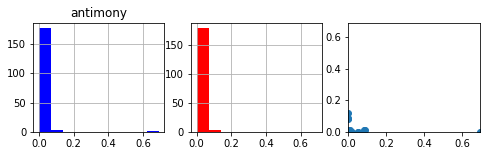

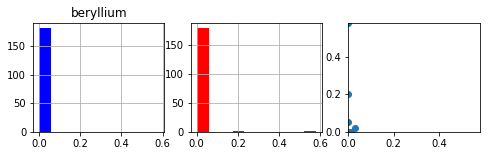

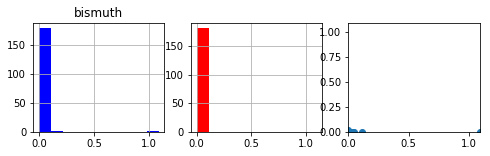

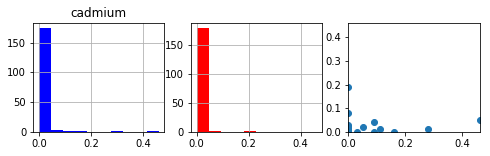

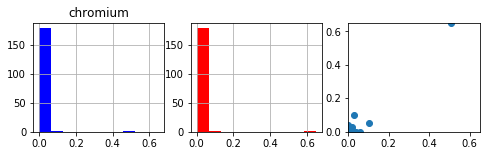

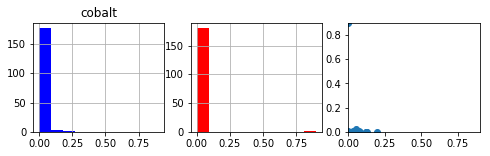

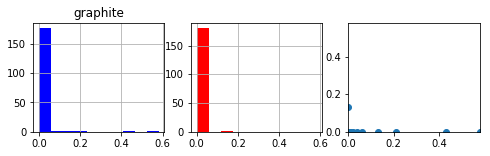

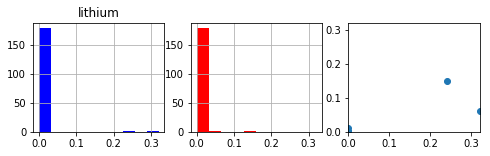

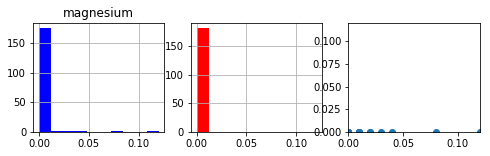

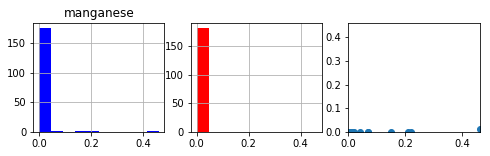

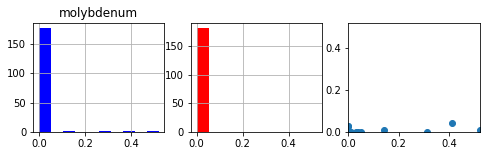

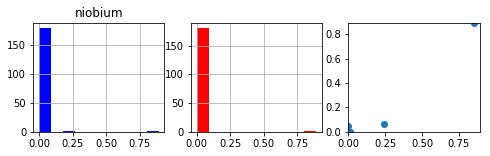

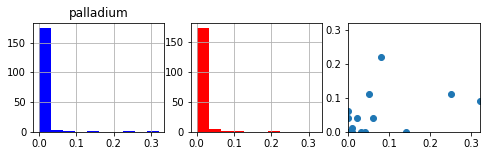

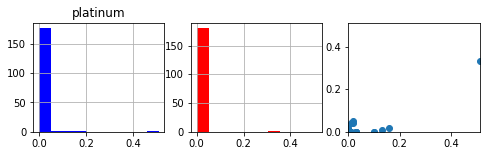

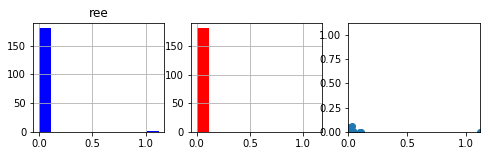

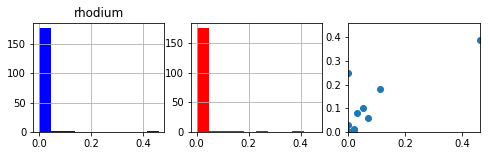

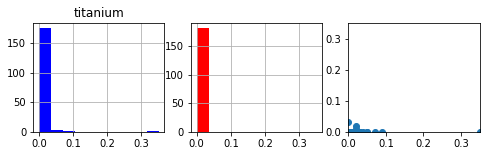

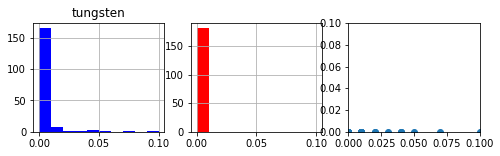

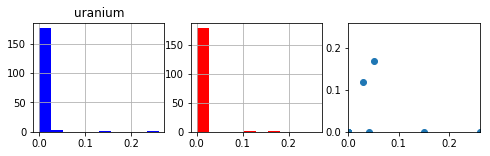

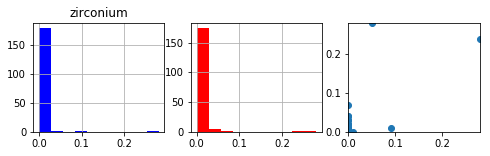

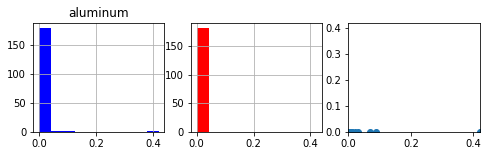

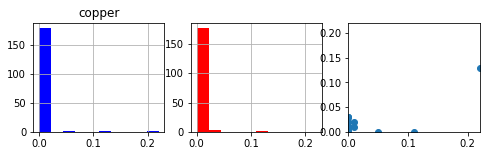

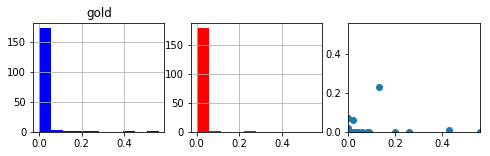

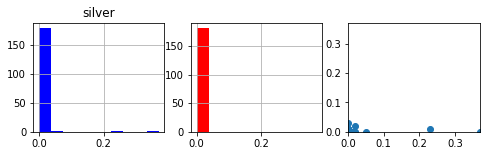

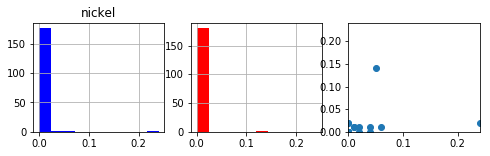

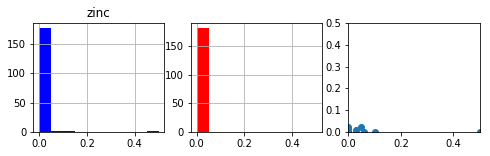

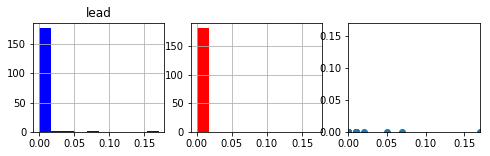

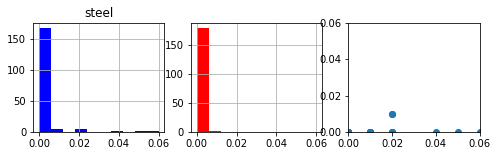

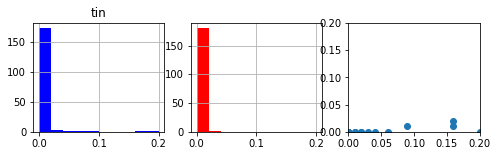

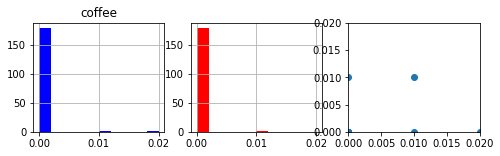

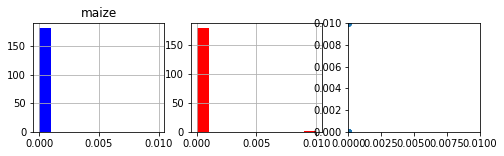

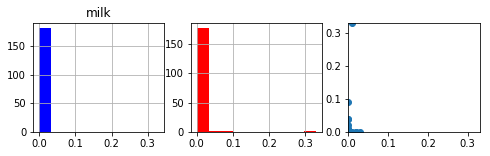

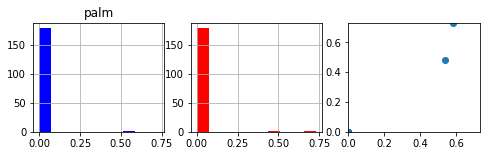

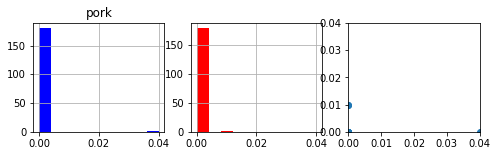

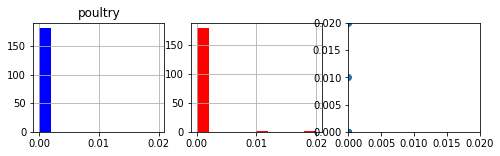

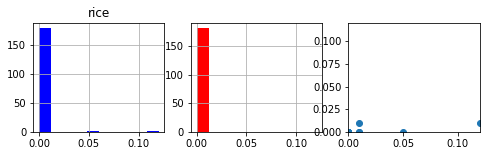

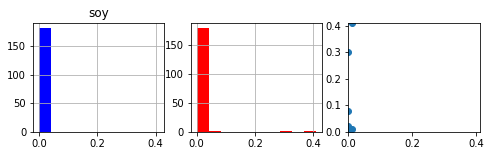

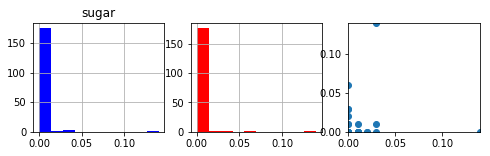

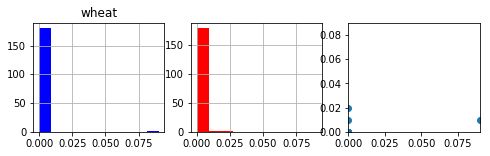

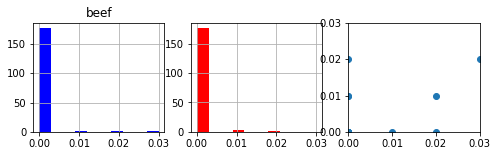

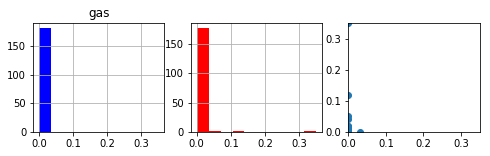

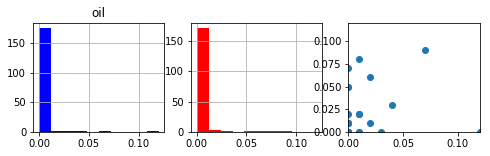

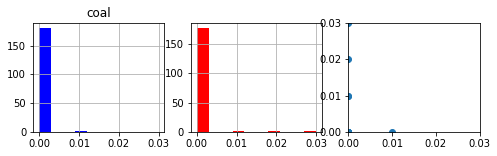

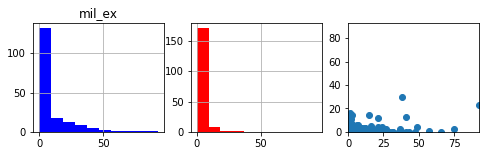

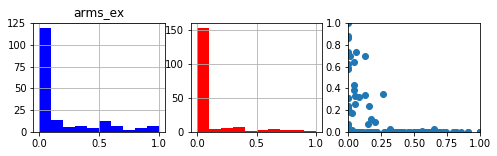

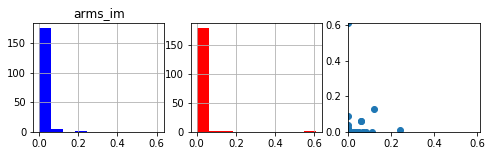

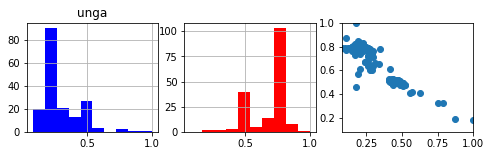

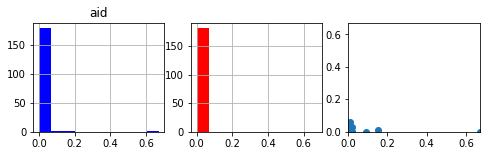

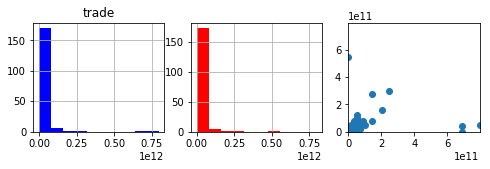

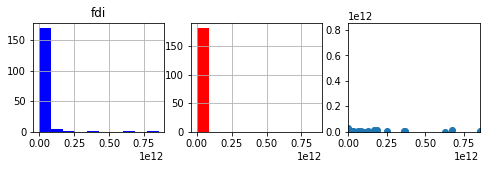

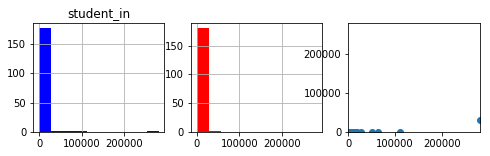

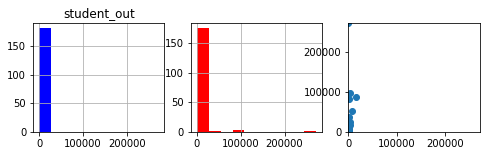

In [185]:
def plots(ind, *args, dat=dat):
    usi = '{}_us'.format(ind)
    cni = '{}_cn'.format(ind)
    if usi in dat:
        both = np.vstack((dat[usi], dat[cni]))
        minv = np.nanmin(both)
        maxv = np.nanmax(both)
        fig, axs = plt.subplots(1, 3, figsize=(8, 2))
        dat[usi].hist(ax=axs[0], color='b', range=(minv, maxv))
        dat[cni].hist(ax=axs[1], color='r', range=(minv, maxv))
        axs[2].scatter(dat[usi], dat[cni])
        axs[2].set_xlim((minv, maxv))
        axs[2].set_ylim((minv, maxv))
        axs[0].set_title(ind)
        fig.show()
iterind(plots)

/usr/local/homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice
/usr/local/homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice


,country,antimony_us,antimony_cn,beryllium_us,beryllium_cn,bismuth_us,bismuth_cn,cadmium_us,cadmium_cn,chromium_us,...,student_in_us,student_in_cn,student_out_us,student_out_cn,students_us,students_cn,soft_us,soft_cn,overall_us,overall_cn
iso,,,,,,,,,,,,,,,,,,,,,
AFG,Afghanistan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.001700,0.000000,0.000000,0.000000,0.000850,0.000000,0.000932,0.002755,0.030697,0.056143
ALB,Albania,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.002340,0.000000,0.000000,0.000000,0.001170,0.000000,0.000463,0.000361,0.038803,0.028415
DZA,Algeria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000569,0.000043,0.000000,0.000000,0.000285,0.000021,0.003156,0.028291,0.010868,0.065348
AGO,Angola,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.004007,0.000171,0.000000,0.000000,0.002003,0.000086,0.003544,0.043271,0.012990,0.110650
ARG,Argentina,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.006825,0.000000,0.057938,0.000525,0.032381,0.000263,0.025207,0.048780,0.053687,0.069693


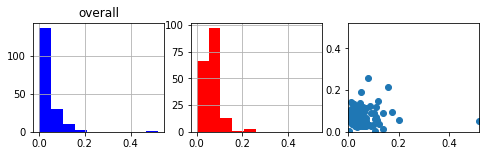

In [190]:
out = pd.DataFrame(index=dat.index)
out['country'] = countries.set_index('iso_a3').drop('-99')['name']
def agg(ind, args):
    usi = '{}_us'.format(ind)
    cni = '{}_cn'.format(ind)
    if args == {} or 'vmin' in args or 'vmax' in args or 'log' in args:
        if usi in dat:
            out[usi] = norm(dat[usi], **args)
            out.at['USA', usi] = np.nan
            if out[usi].min() == out[usi].max():
                out[usi] = np.nan
            out[cni] = norm(dat[cni], **args)
            out.at['CHN', cni] = np.nan
            if out[cni].min() == out[cni].max():
                out[cni] = np.nan
    else:
        usargs = ['{}_us'.format(arg) for arg in args]
        cnargs = ['{}_cn'.format(arg) for arg in args]
        out[usi] = np.nanmean(out[usargs], axis=1)
        out[cni] = np.nanmean(out[cnargs], axis=1)
iterind(agg)
plots('overall', dat=out)
out.head()

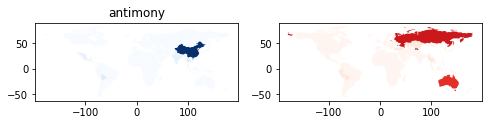

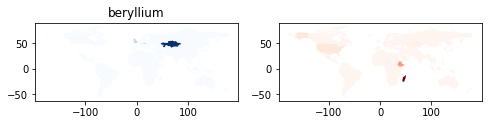

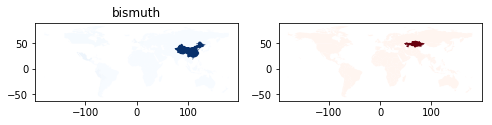

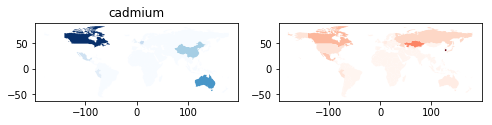

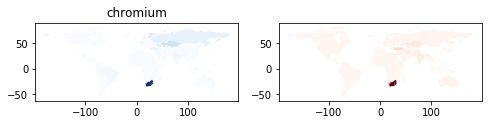

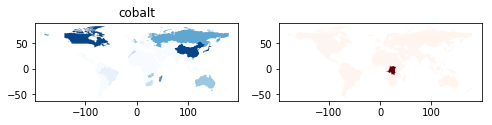

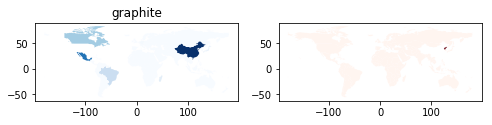

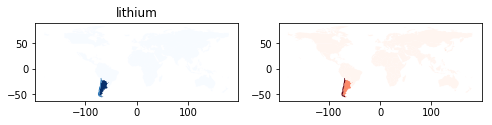

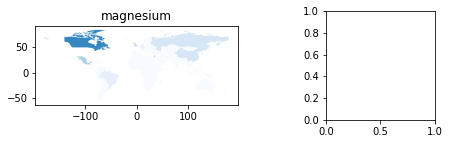

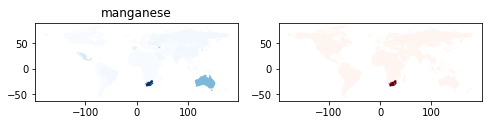

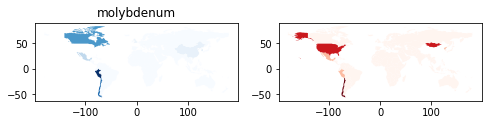

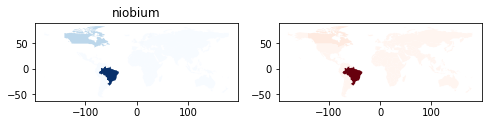

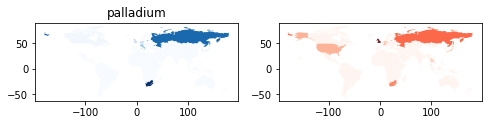

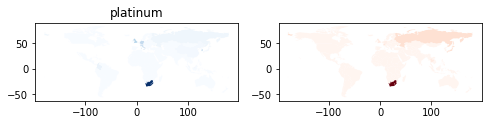

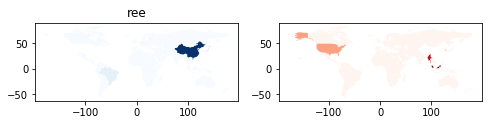

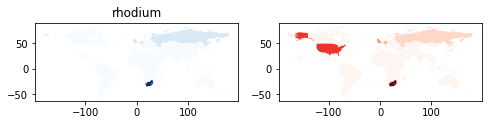

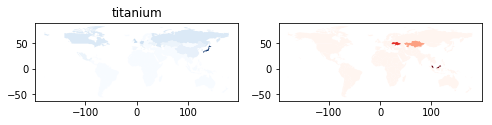

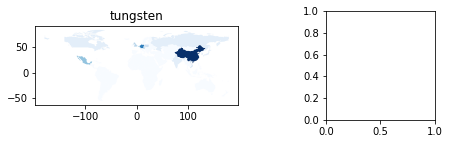

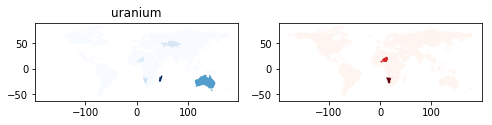

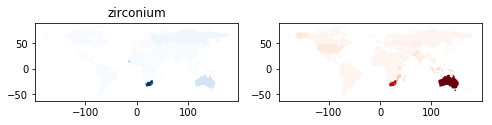

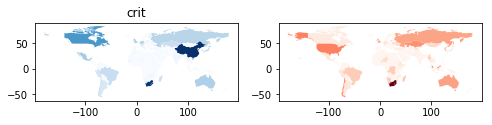

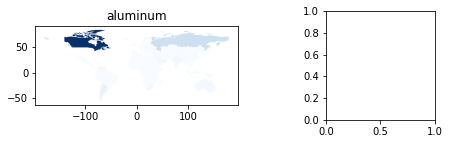

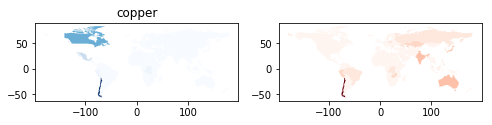

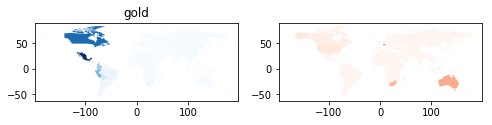

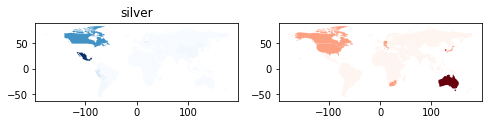

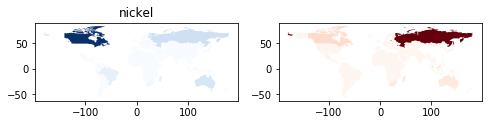

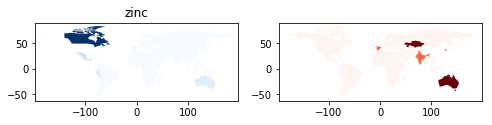

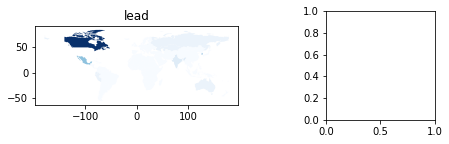

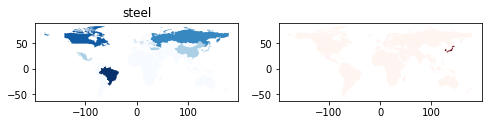

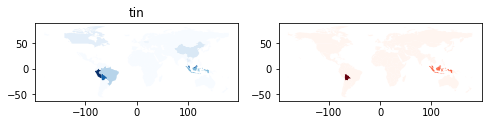

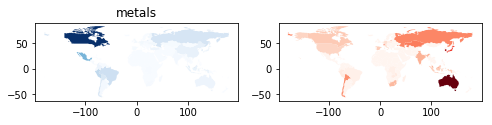

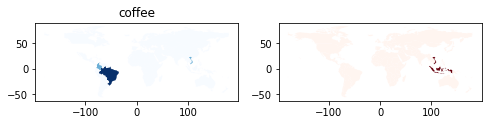

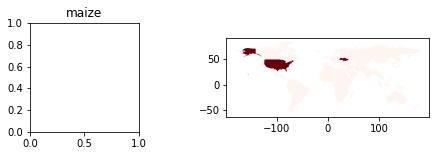

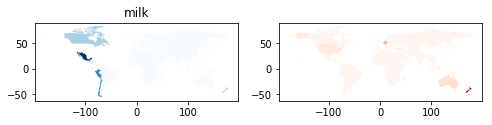

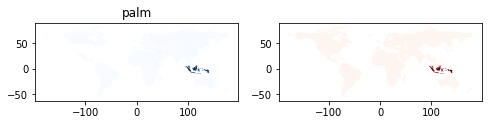

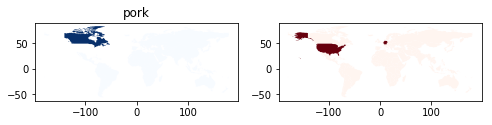

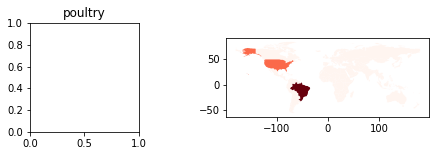

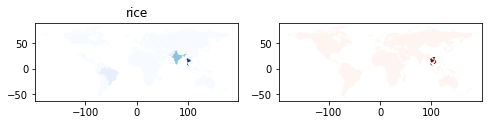

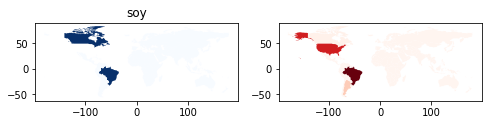

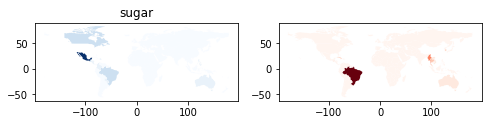

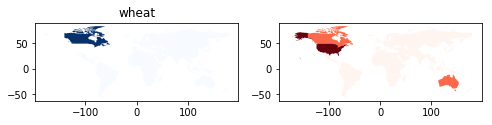

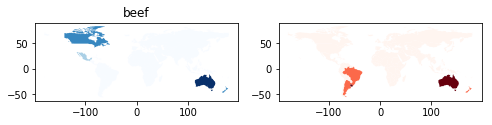

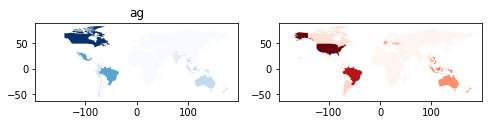

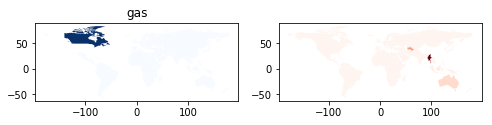

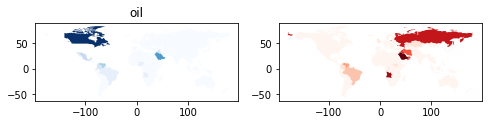

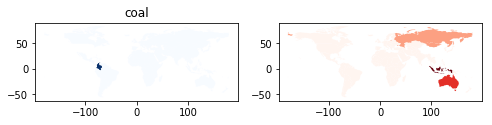

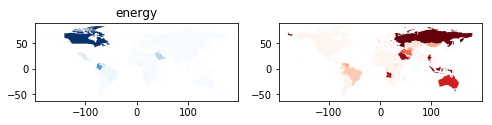

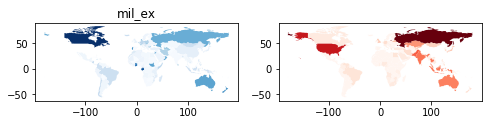

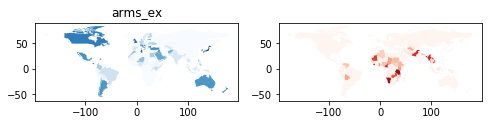

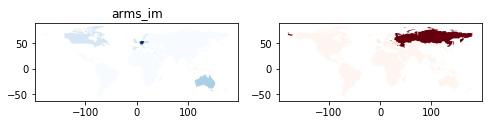

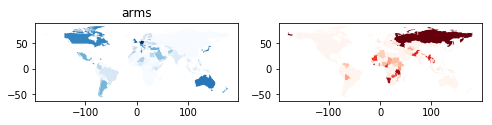

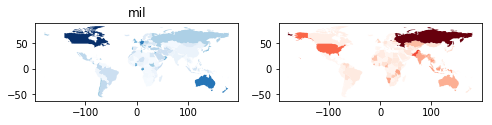

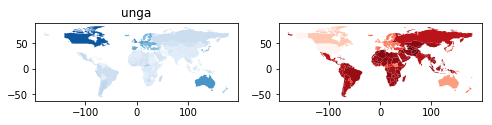

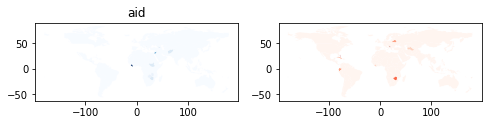

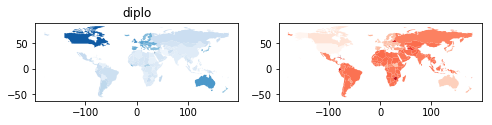

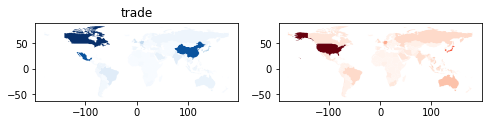

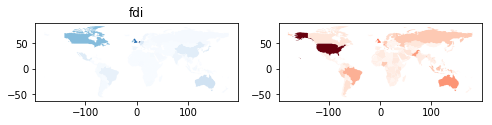

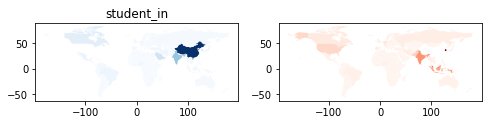

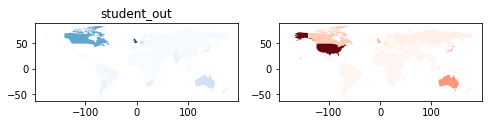

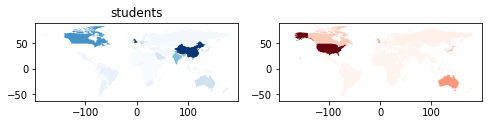

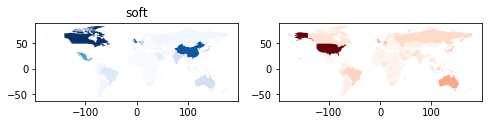

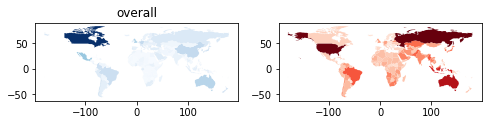

In [194]:
shp2 = shps.set_index('ISO_A3').join(out)
def maps(ind, *args, dat=dat):
    usi = '{}_us'.format(ind)
    cni = '{}_cn'.format(ind)
    if usi in dat:
        fig, axs = plt.subplots(1, 2, figsize=(8, 2))
        shp2[shp2[usi].notna()].plot(usi, ax=axs[0], cmap='Blues')
        shp2[shp2[cni].notna()].plot(cni, ax=axs[1], cmap='Reds')
        axs[0].set_title(ind)
        fig.show()
iterind(maps, dat=out)

In [195]:
def tops(ind, *args, dat=dat):
    usi = '{}_us'.format(ind)
    cni = '{}_cn'.format(ind)
    if usi in dat:
        print(ind)
        print(dat.set_index('country')[usi].sort_values(ascending=False).head())
        print(dat.set_index('country')[cni].sort_values(ascending=False).head())
        print('\n')
iterind(tops, dat=out)

antimony
country
China       1.000000
Thailand    0.130435
Belgium     0.115942
Bolivia     0.115942
India       0.072464
Name: antimony_us, dtype: float64
country
Tajikistan    1.000000
Russia        0.750000
Australia     0.666667
Laos          0.083333
Turkey        0.083333
Name: antimony_cn, dtype: float64


beryllium
country
Kazakhstan        1.000000
Czech Republic    0.333333
United Kingdom    0.333333
Zimbabwe          0.000000
Swaziland         0.000000
Name: beryllium_us, dtype: float64
country
Madagascar                  1.000000
Ethiopia                    0.344828
United States of America    0.086207
Kazakhstan                  0.034483
Zimbabwe                    0.000000
Name: beryllium_cn, dtype: float64


bismuth
country
China          1.000000
Belgium        0.100917
Mexico         0.045872
South Korea    0.036697
Peru           0.027523
Name: bismuth_us, dtype: float64
country
Kazakhstan    1.0
Zimbabwe      0.0
Ethiopia      0.0
Greece        0.0
Ghana         0.0


country
The Bahamas    0.770325
Montenegro     0.701220
Zimbabwe       0.609756
Cuba           0.538618
Ecuador        0.538618
Name: diplo_cn, dtype: float64


trade
country
Canada     1.000000
China      0.866708
Mexico     0.866507
Japan      0.308566
Germany    0.255495
Name: trade_us, dtype: float64
country
United States of America    1.000000
Japan                       0.539822
South Korea                 0.500538
Germany                     0.297168
Australia                   0.230232
Name: trade_cn, dtype: float64


fdi
country
Netherlands       1.000000
United Kingdom    0.789130
Luxembourg        0.734883
Canada            0.435504
Ireland           0.423794
Name: fdi_us, dtype: float64
country
United States of America    1.000000
United Kingdom              0.491162
Switzerland                 0.462775
Australia                   0.365203
Pakistan                    0.344046
Name: fdi_cn, dtype: float64


student_in
country
China           1.000000
India           0.391182